In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import re
import time

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from nltk import word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from langdetect import detect_langs

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
import string
import lightgbm as lgb 
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, log_loss
from sklearn.metrics import roc_curve, auc, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

import sys
if not sys.warnoptions:
        import warnings
        #suppress warning messages (those with peach background)
        warnings.simplefilter("ignore")

In [2]:
# Widen width of notebook and increase dataframe dimensions
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [3]:
df=pd.read_csv('twitter_sentiment_data.csv')
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


In [4]:
df=df.drop_duplicates('message',keep='first')
df=df.reset_index()

In [5]:
df.shape

(41033, 4)

sentiment distribution
 1    20599
 2     9073
 0     7505
-1     3856
Name: sentiment, dtype: int64


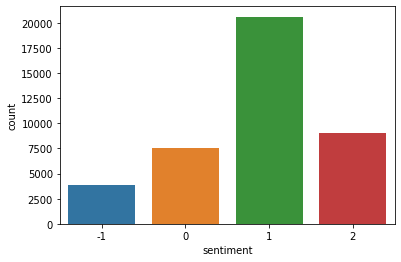

In [6]:
print('sentiment distribution')
print(df.sentiment.value_counts())
sns.countplot(x='sentiment', data=df)
plt.show()

In [7]:
n=3856
df_neg1=df.query('sentiment == -1').sample(n)
df_0=df.query('sentiment == 0').sample(n)
df_1=df.query('sentiment == 1').sample(n)
df_2=df.query('sentiment == 2').sample(n)
df=pd.concat([df_neg1,df_0, df_1,df_2])
df=df.reset_index()
df.head()

,level_0,index,sentiment,message,tweetid
0,3784,6153,-1,#TEAParty https://t.co/mcCHdVbq5T Lord Monckto...,798945764298919937
1,33752,36652,-1,Trump thinks he's debunked climate change by t...,963801699608616961
2,37632,40538,-1,RT @cristinalaila1: 4 more days until @algore$...,691047815187951618
3,18094,20988,-1,"the UN blames you for climate change, meanwhil...",862326420961460228
4,39819,42727,-1,RT @DLoesch: All the people there mad about cl...,761740803383238656


### Data Exploration

In [8]:
df.shape

(15424, 5)

In [9]:
df.sentiment.value_counts()

-1    3856
 2    3856
 1    3856
 0    3856
Name: sentiment, dtype: int64

In [10]:
df.isnull().sum()

level_0      0
index        0
sentiment    0
message      0
tweetid      0
dtype: int64

In [11]:
df.dtypes

level_0       int64
index         int64
sentiment     int64
message      object
tweetid       int64
dtype: object

### Feature engineering

In [12]:
df['num_char'] = df['message'].str.len()
df['num_word'] = df['message'].str.split().map(lambda x: len(x))
df['ave_word_length'] = df['num_char'] / df['num_word'] 
df['punctuation_count'] = df["message"].apply(lambda x: len([w for w in str(x) if w in string.punctuation]) )
df['num_punctuation'] = df.message.str.count('[^\w\s]')

In [13]:
df.head()

,level_0,index,sentiment,message,tweetid,num_char,num_word,ave_word_length,punctuation_count,num_punctuation
0,3784,6153,-1,#TEAParty https://t.co/mcCHdVbq5T Lord Monckto...,798945764298919937,123,15,8.200000,6,6
1,33752,36652,-1,Trump thinks he's debunked climate change by t...,963801699608616961,141,18,7.833333,14,16
2,37632,40538,-1,RT @cristinalaila1: 4 more days until @algore$...,691047815187951618,141,15,9.400000,13,13
3,18094,20988,-1,"the UN blames you for climate change, meanwhil...",862326420961460228,107,15,7.133333,8,10
4,39819,42727,-1,RT @DLoesch: All the people there mad about cl...,761740803383238656,121,23,5.260870,3,3


In [14]:
df.describe()

,level_0,index,sentiment,tweetid,num_char,num_word,ave_word_length,punctuation_count,num_punctuation
count,15424.000000,15424.000000,15424.00000,1.542400e+04,15424.000000,15424.000000,15424.000000,15424.000000,15424.000000
mean,20928.527425,23664.177256,0.50000,8.374177e+17,119.992933,16.928423,7.325892,7.671486,8.572614
std,11796.892775,12073.765898,1.11807,8.923912e+16,26.186145,4.789365,1.349913,3.637094,4.475083
min,0.000000,0.000000,-1.00000,5.927030e+17,7.000000,1.000000,3.564103,0.000000,0.000000
25%,10763.250000,13653.250000,-0.25000,7.975083e+17,106.000000,14.000000,6.363636,5.000000,6.000000
50%,20839.500000,23735.500000,0.50000,8.423084e+17,130.000000,17.000000,7.146429,7.000000,8.000000
75%,31286.250000,34185.250000,1.25000,9.050898e+17,140.000000,20.000000,8.083333,10.000000,11.000000
max,41031.000000,43941.000000,2.00000,9.666876e+17,623.000000,97.000000,32.500000,36.000000,185.000000


In [15]:
df.groupby('sentiment').describe()

level_0                                                      \
            count          mean           std   min      25%      50%   
sentiment                                                               
-1         3856.0  22079.851660  11590.936683   0.0  12157.0  22001.5   
 0         3856.0  22445.492998  11986.221645   5.0  12200.0  24046.5   
 1         3856.0  20266.258039  11845.049227  14.0   9776.5  20640.0   
 2         3856.0  18922.507002  11417.484601   4.0   9439.5  16957.5   

                               index                                    \
                75%      max   count          mean           std   min   
sentiment                                                                
-1         32488.75  41025.0  3856.0  24874.957988  11779.817927   0.0   
 0         32666.25  41031.0  3856.0  25166.036826  12310.059248   5.0   
 1         30525.50  41026.0  3856.0  22949.444761  12194.460312  16.0   
 2         28391.00  41030.0  3856.0  21666.269450  11661.218678   4.0   

                                               tweetid                \
               25%      50%       75%      max   count          mean   
sentiment                                                              
-1         15047.0  24897.5  35387.75  43935.0  3856.0  8.331735e+17   
 0         15090.0  26942.5  35565.25  43941.0  3856.0  8.398739e+17   
 1         12665.5  23536.0  33424.50  43936.0  3856.0  8.448577e+17   
 2         12328.5  19850.5  31290.00  43940.0  3856.0  8.317655e+17   

                                                                   \
                    std           min           25%           50%   
sentiment                                                           
-1         9.382540e+16  5.928605e+17  7.966736e+17  8.418629e+17   
 0         9.479116e+16  5.933584e+17  7.948221e+17  8.443073e+17   
 1         8.490792e+16  5.930263e+17  7.983026e+17  8.450051e+17   
 2         8.216680e+16  5.927030e+17  7.997441e+17  8.411010e+17   

                                      num_char                               \
                    75%           max    count        mean        std   min   
sentiment                                                                     
-1         9.032513e+17  9.664135e+17   3856.0  123.668050  24.584353  22.0   
 0         9.241731e+17  9.665111e+17   3856.0  110.353475  34.147453   7.0   
 1         9.083977e+17  9.666876e+17   3856.0  126.456950  21.286501  28.0   
 2         8.743561e+17  9.655369e+17   3856.0  119.493257  19.270158  37.0   

                                      num_word                            \
             25%    50%    75%    max    count       mean       std  min   
sentiment                                                                  
-1         114.0  135.0  140.0  172.0   3856.0  18.067687  4.662830  2.0   
 0          84.0  121.0  140.0  623.0   3856.0  16.139782  5.798556  1.0   
 1         118.0  136.0  140.0  179.0   3856.0  18.234440  4.302265  2.0   
 2         106.0  122.0  137.0  166.0   3856.0  15.271784  3.394631  3.0   

                                  ave_word_length                      \
            25%   50%   75%   max           count      mean       std   
sentiment                                                               
-1         15.0  19.0  21.0  30.0          3856.0  7.058134  1.261924   
 0         12.0  17.0  21.0  97.0          3856.0  7.117259  1.562221   
 1         15.0  19.0  21.0  39.0          3856.0  7.140567  1.227597   
 2         13.0  15.0  18.0  26.0          3856.0  7.987607  1.078385   

                                                              \
                min       25%       50%       75%        max   
sentiment                                                      
-1         4.350000  6.216615  6.833333  7.692308  24.000000   
 0         4.375000  6.095238  6.818182  7.777778  32.500000   
 1         3.564103  6.303261  7.000000  7.812500  20.666667   
 2     

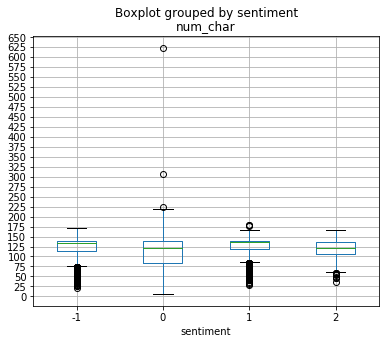

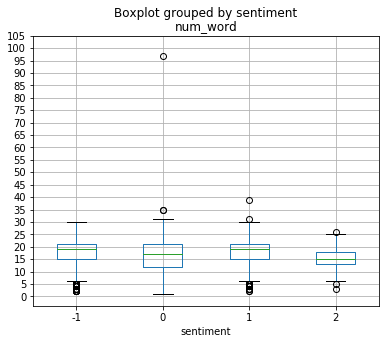

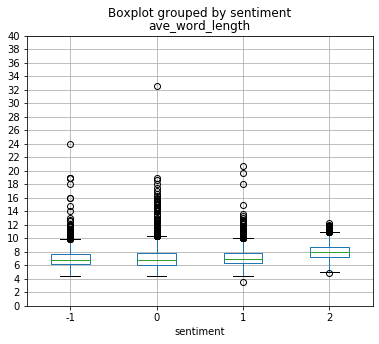

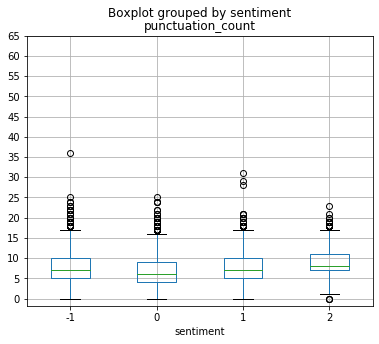

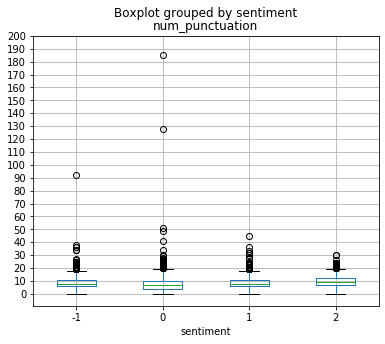

In [16]:
ax = df.boxplot('num_char', by='sentiment', rot=0, figsize=(6, 5))
ax.set_yticks(np.arange(0,675,step=25))
ax = df.boxplot('num_word', by='sentiment', rot=0, figsize=(6, 5))
ax.set_yticks(np.arange(0,106,step=5))
ax = df.boxplot('ave_word_length', by='sentiment', rot=0, figsize=(6, 5))
ax.set_yticks(np.arange(0,42,step=2))
ax = df.boxplot('punctuation_count', by='sentiment', rot=0, figsize=(6, 5))
ax.set_yticks(np.arange(0,66,step=5))
ax = df.boxplot('num_punctuation', by='sentiment', rot=0, figsize=(6, 5))
ax.set_yticks(np.arange(0,210,step=10))
plt.show()

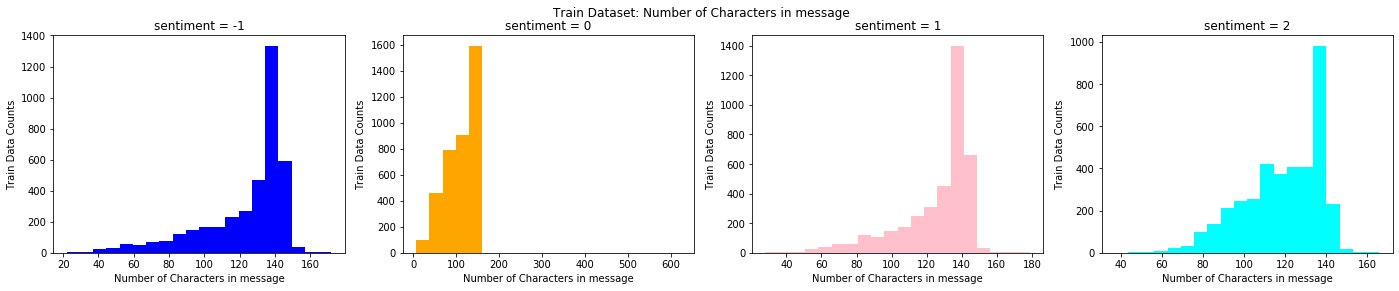

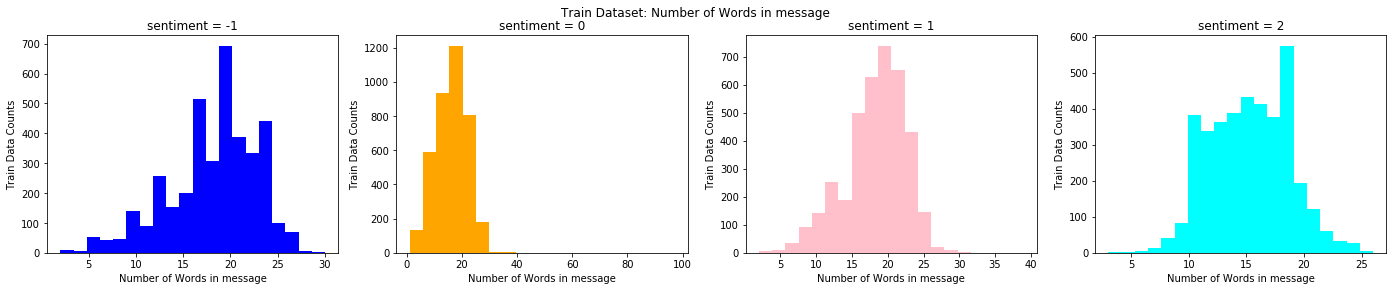

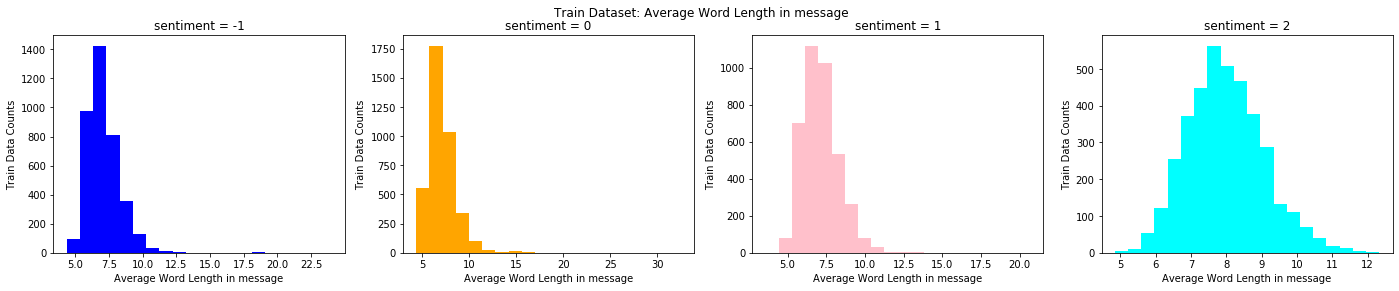

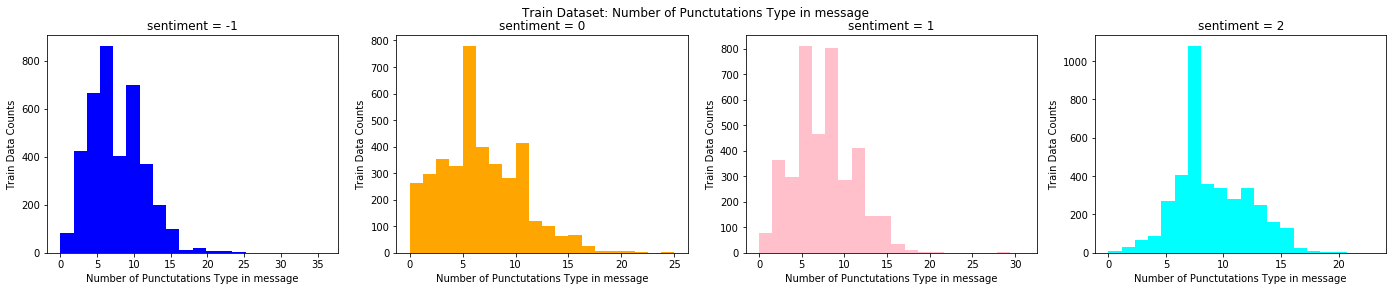

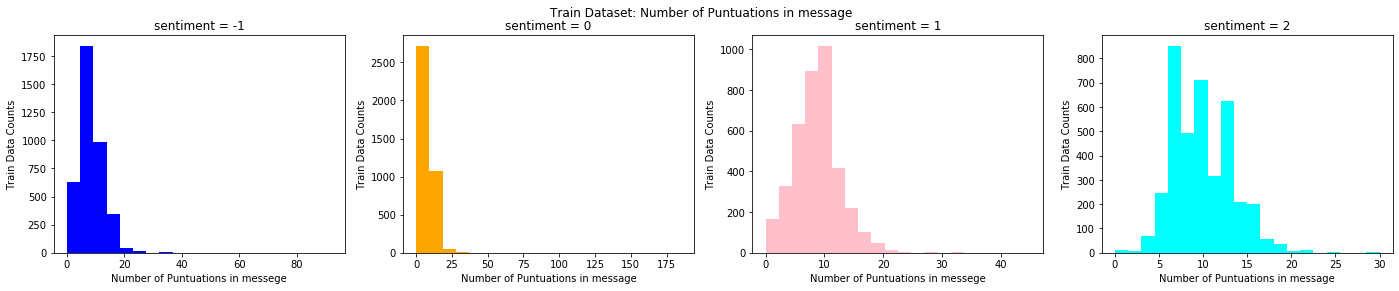

In [17]:
# Number of Characters in message
fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24,4))
text_len=df[df['sentiment']==-1]['num_char']
ax1.hist(text_len,color='blue', bins=20)
ax1.set_title('sentiment = -1')
ax1.set_xlabel("Number of Characters in message") 
ax1.set_ylabel("Train Data Counts")
text_len=df[df['sentiment']==0]['num_char']
ax2.hist(text_len,color='orange', bins=20)
ax2.set_title('sentiment = 0')
ax2.set_xlabel("Number of Characters in message") 
ax2.set_ylabel("Train Data Counts")
fig.suptitle('Train Dataset: Number of Characters in message')
text_len=df[df['sentiment']==1]['num_char']
ax3.hist(text_len,color='pink', bins=20)
ax3.set_title('sentiment = 1')
ax3.set_xlabel("Number of Characters in message") 
ax3.set_ylabel("Train Data Counts")
fig.suptitle('Train Dataset: Number of Characters in message')
text_len=df[df['sentiment']==2]['num_char']
ax4.hist(text_len,color='cyan', bins=20)
ax4.set_title('sentiment = 2')
ax4.set_xlabel("Number of Characters in message") 
ax4.set_ylabel("Train Data Counts")
fig.suptitle('Train Dataset: Number of Characters in message')
plt.show()

# Number of Words in a message
fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24,4))
text_len=df[df['sentiment']==-1]['num_word']
ax1.hist(text_len,color='blue', bins=20)
ax1.set_title('sentiment = -1')
ax1.set_xlabel("Number of Words in message") 
ax1.set_ylabel("Train Data Counts")
text_len=df[df['sentiment']==0]['num_word']
ax2.hist(text_len,color='orange', bins=20)
ax2.set_title('sentiment = 0')
ax2.set_xlabel("Number of Words in message") 
ax2.set_ylabel("Train Data Counts")
fig.suptitle('Train Dataset: Number of Words in message')
text_len=df[df['sentiment']==1]['num_word']
ax3.hist(text_len,color='pink', bins=20)
ax3.set_title('sentiment = 1')
ax3.set_xlabel("Number of Words in message") 
ax3.set_ylabel("Train Data Counts")
text_len=df[df['sentiment']==2]['num_word']
ax4.hist(text_len,color='cyan', bins=20)
ax4.set_title('sentiment = 2')
ax4.set_xlabel("Number of Words in message") 
ax4.set_ylabel("Train Data Counts")
fig.suptitle('Train Dataset: Number of Words in message')
plt.show()

# Average Word Length in a message
fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24,4))
text_len=df[df['sentiment']==-1]['ave_word_length']
ax1.hist(text_len,color='blue', bins=20)
ax1.set_title('sentiment = -1')
ax1.set_xlabel("Average Word Length in message") 
ax1.set_ylabel("Train Data Counts")
text_len=df[df['sentiment']==0]['ave_word_length']
ax2.hist(text_len,color='orange', bins=20)
ax2.set_title('sentiment = 0')
ax2.set_xlabel("Average Word Length in message") 
ax2.set_ylabel("Train Data Counts")
fig.suptitle('Train Dataset: Average Word Length in message')
text_len=df[df['sentiment']==1]['ave_word_length']
ax3.hist(text_len,color='pink', bins=20)
ax3.set_title('sentiment = 1')
ax3.set_xlabel("Average Word Length in message") 
ax3.set_ylabel("Train Data Counts")
text_len=df[df['sentiment']==2]['ave_word_length']
ax4.hist(text_len,color='cyan', bins=20)
ax4.set_title('sentiment = 2')
ax4.set_xlabel("Average Word Length in message") 
ax4.set_ylabel("Train Data Counts")
fig.suptitle('Train Dataset: Average Word Length in message')
plt.show()

# Number type of Punctuations in a message
fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24,4))
text_len=df[df['sentiment']==-1]['punctuation_count']
ax1.hist(text_len,color='blue', bins=20)
ax1.set_title('sentiment = -1')
ax1.set_xlabel("Number of Punctutations Type in message") 
ax1.set_ylabel("Train Data Counts")
text_len=df[df['sentiment']==0]['punctuation_count']
ax2.hist(text_len,color='orange', bins=20)
ax2.set_title('sentiment = 0')
ax2.set_xlabel("Number of Punctutations Type in message") 
ax2.set_ylabel("Train Data Counts")
fig.suptitle('Train Dataset: Type of Stopwords in message')
text_len=df[df['sentiment']==1]['punctuation_count']
ax3.hist(text_len,color='pink', bins=20)
ax3.set_title('sentiment = 1')
ax3.set_xlabel("Number of Punctutations Type in message") 
ax3.set_ylabel("Train Data Counts")
text_len=df[df['sentiment']==2]['punctuation_count']
ax4.hist(text_len,color='cyan', bins=20)
ax4.set_title('sentiment = 2')
ax4.set_xlabel("Number of Punctutations Type in message") 
ax4.set_ylabel("Train Data Counts")
fig.suptitle('Train Dataset: Number of Punctutations Type in message')
plt.show()

# Number of Puntuations in a message
fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24,4))
text_len=df[df['sentiment']==-1]['num_punctuation']
ax1.hist(text_len,color='blue', bins=20)
ax1.set_title('sentiment = -1')
ax1.set_xlabel("Number of Puntuations in messege") 
ax1.set_ylabel("Train Data Counts")
text_len=df[df['sentiment']==0]['num_punctuation']
ax2.hist(text_len,color='orange', bins=20)
ax2.set_title('sentiment = 0')
ax2.set_xlabel("Number of Puntuations in message") 
ax2.set_ylabel("Train Data Counts")
fig.suptitle('Train Dataset: Number of Puntuations in message')
text_len=df[df['sentiment']==1]['num_punctuation']
ax3.hist(text_len,color='pink', bins=20)
ax3.set_title('sentiment = 1')
ax3.set_xlabel("Number of Puntuations in messege") 
ax3.set_ylabel("Train Data Counts")
text_len=df[df['sentiment']==2]['num_punctuation']
ax4.hist(text_len,color='cyan', bins=20)
ax4.set_title('sentiment = 2')
ax4.set_xlabel("Number of Puntuations in message") 
ax4.set_ylabel("Train Data Counts")
fig.suptitle('Train Dataset: Number of Puntuations in message')
plt.show()

### Text processing

In [18]:
#text processing steps definition

def html_tag_remover(text):
    soup = BeautifulSoup(text)
    text_out = soup.get_text()
    return text_out

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# def stopwords_remove(text):
#     STOPWORDS = set(stopwords.words('english'))
#     text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
#     return text

def CleanMessage(df):
    df['message'] = df.message.apply(lambda x:html_tag_remover(x))
   # df['message']=df['message'].apply(lambda x : remove_html(x)) # Remove HTML
    df['message']=df['message'].apply(lambda x : remove_URL(x)) 
    
    df['message'] = df['message'].str.lower()
    df['message'] = df['message'].str.replace(r'[^a-z]+',' ')
    df['message'] = df['message'].str.replace(r'[\s+]', ' ')

    df['message'] = df['message'].str.replace('leonardo','dicaprio')
    df['message'] = df['message'].str.replace('leodicaprio','dicaprio')
    df['message'] = df['message'].str.replace('leo','dicaprio')
#     df['message'] = df['message'].apply(stopwords_remove) #stopwords
    print('The messages have been cleaned')
    #return df           

def Lemma(df):
    df['message_toc']=[word_tokenize(text) for text in df['message']]
    WNLemmatizer=WordNetLemmatizer()
    df['message_lem']=[[WNLemmatizer.lemmatize(word) for word in token] for token in df['message_toc']]
    df['message_len_str'] = df.message_lem.astype(str)  
    print('The messages have been tokenized and lemmatized')
    return df

def WorldCloudBuilt(df):
    text=df['message'].str.cat()
    my_stopwords=set(STOPWORDS)
    my_stopwords.update(['many','will','via','thing','one','say','rt','https rt'])
    text=WordCloud(background_color="white",max_words=100, stopwords=my_stopwords).generate(text)
    
    plt.figure(figsize=(20,10))
    plt.imshow(text, interpolation='bilinear')
    plt.axis('off')
    plt.show()   
    
def WorldCloudBuilt_USA(df):
    usa_map = np.array(Image.open("hiclipart_usa_map.png"))  
    text=df['message'].str.cat()
    my_stopwords=set(STOPWORDS)
    my_stopwords.update(['many','will','via','thing','one','say','rt','https rt'])
    wordcloud = WordCloud(
        background_color = 'white', 
        mode = "RGBA",
        max_words = 2000,
        mask=usa_map,
        stopwords = my_stopwords).generate(str(text))

    plt.figure(figsize = (21, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    wordcloud.to_file('usa_map_wordcloud_white.png')
    
    wordcloud_black = WordCloud(
    background_color = 'black', 
    mode = "RGBA",
    max_words = 2000,
    mask=usa_map,
    stopwords = my_stopwords).generate(str(text))

    plt.figure(figsize = (20, 10))
    plt.imshow(wordcloud_black, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    wordcloud.to_file('usa_map_wordcloud_Black.png')

The messages have been cleaned
The messages have been tokenized and lemmatized

Fist 1000 strings after cleaning: 
 teaparty lord monckton shows ipcc pachauri is dishonest about global warming after being correctedtrump thinks he s debunked climate change by the fact that it got colder for him watch rt cristinalaila more days until algore q s global warming snowzilla doomsday clock expires snowmaggedon the un blames you for climate change meanwhile ignores this opchemtrails srmrt dloesch all the people there mad about climate change must have left super early to take all those row boats to rio  cnn there s a link between climate change and bs world leaders duped by manipulated global warming data via mailonlinert deneenborelli the global warming intimidation game exposed tomborelli cr dncinphl pjnet rt magathom in new england was devastated by a huge cat hurricane neither global warming nor democrat president fdr we wondering if the liberals running around in a tee shirt and shorts tod

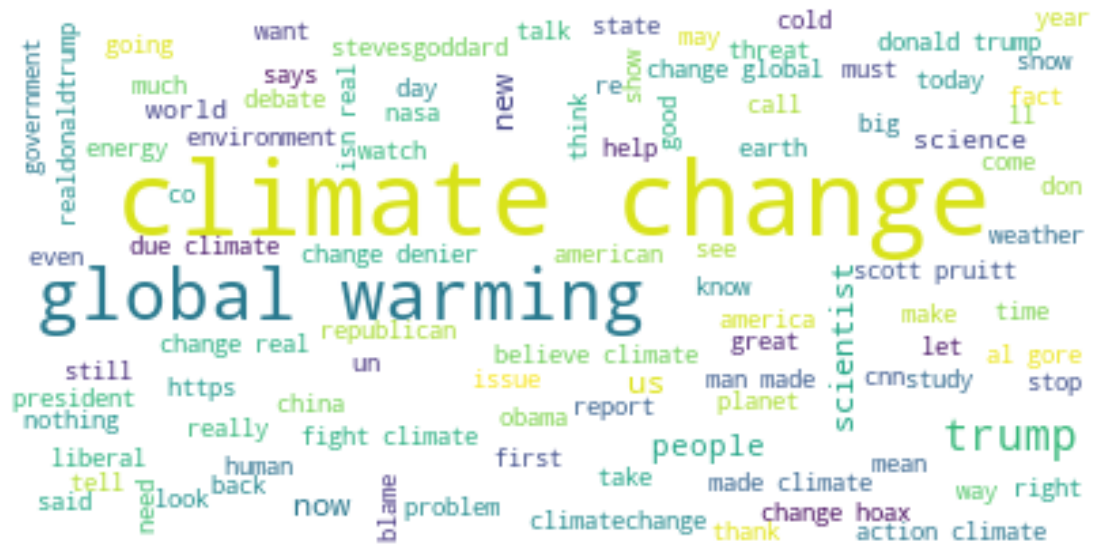

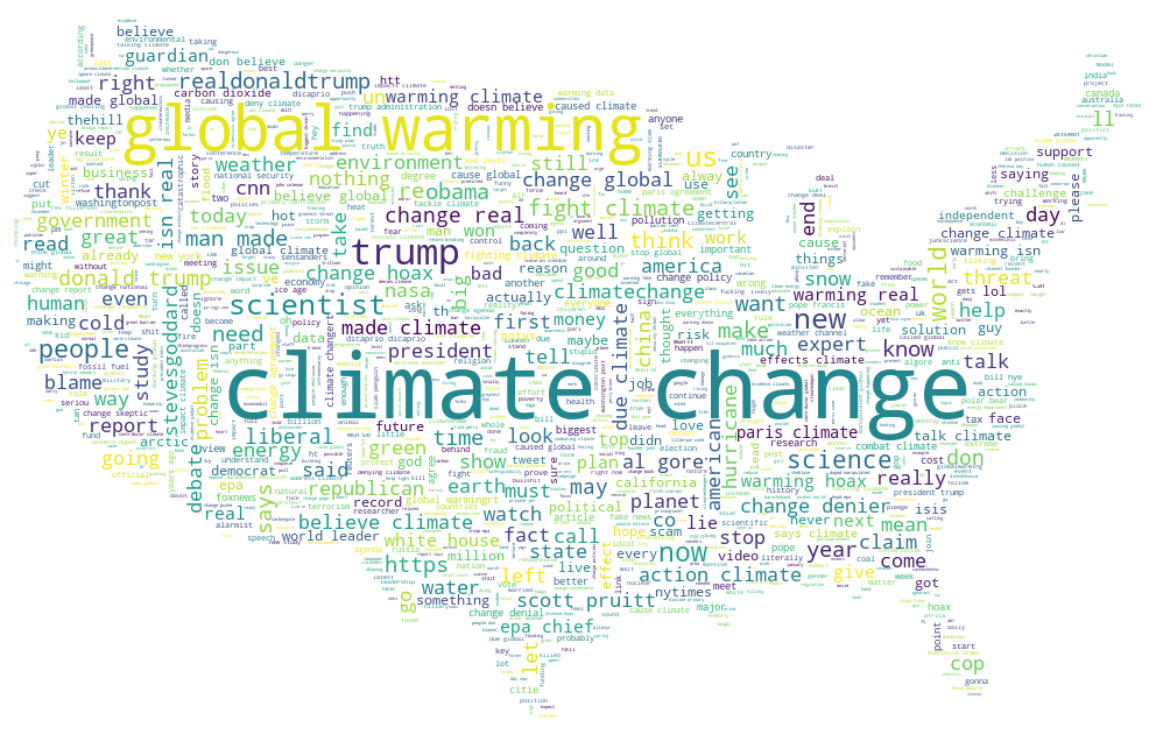

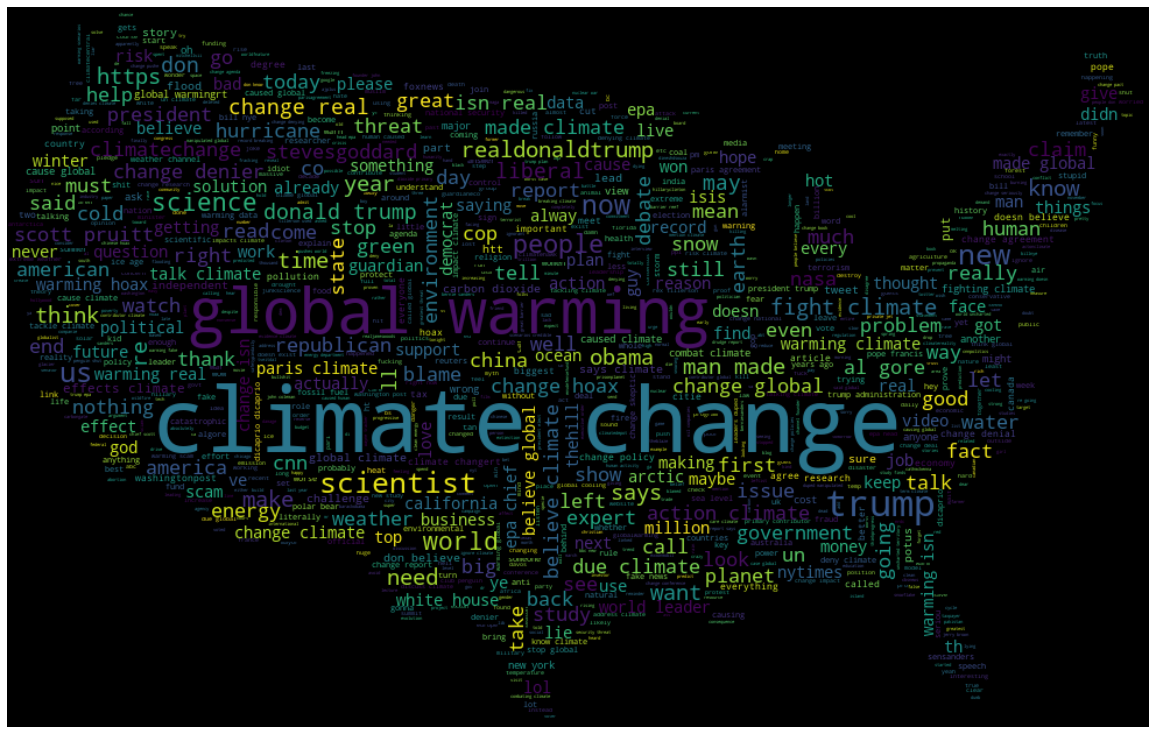

In [19]:
# text processing  for Kaggle dataset
CleanMessage(df)
Lemma(df)
print('\nFist 1000 strings after cleaning: ')
print(df['message'].str.cat()[:1000])
WorldCloudBuilt(df)
WorldCloudBuilt_USA(df)

In [20]:
#other than english language detection

languages=[]
rows_error=[]
for row in range(len(df)):
    try:
        languages.append(detect_langs(df.loc[row,'message']))
    except:
        language = "error"
        rows_error.append(row)
            
str(languages[0]).split(':')
str(languages[0]).split(':')[0]
str(languages[0]).split(':')[0][1:]
languages=[str(lang).split(':')[0][1:] for lang in languages]
    
df=df.drop(rows_error,axis=0)
    
df['language']=languages
df = df[df.language =='en']
print('The messages in other than english languagge have been removed. The dataset has',df.shape[0],'rows.')

The messages in other than english languagge have been removed. The dataset has 15052 rows.


In [21]:
df.to_csv('kaggleTweets_cleaned_undersamplig_dupl.csv')

### Converting text to vectors

In [22]:
df_copy = df.copy()
X=df_copy.message_len_str.to_list()
y=df_copy.sentiment.to_list()

logreg=LogisticRegression()
vect=CountVectorizer()

vect=CountVectorizer()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10,stratify=y)
X_train_vect=vect.fit_transform(X_train)
X_test_vect=vect.transform(X_test)

print(vect.get_feature_names()[:10])

['aaaaaand', 'aamir', 'aardayburnin', 'aarne', 'aarnwlsn', 'aaron', 'aaroncarter', 'aaronnrice', 'aaronwherry', 'aarushiguptax']


In [23]:
X_train_vect.shape

(12041, 19418)

In [24]:
logreg.fit(X_train_vect, y_train)
print('accuracy on training data: ', logreg.score(X_train_vect, y_train))
print('accuracy on testing data: ',accuracy_score(y_test, logreg.predict(X_test_vect)))

class_report=classification_report(y_test, logreg.predict(X_test_vect))
print('\nClassification report for Logistic Regression alogorithm: \n')
print(class_report)

accuracy on training data:  0.964122581180965
accuracy on testing data:  0.6453005645964796

Classification report for Logistic Regression alogorithm: 

              precision    recall  f1-score   support

          -1       0.70      0.69      0.69       763
           0       0.55      0.52      0.53       721
           1       0.59      0.58      0.58       765
           2       0.72      0.80      0.76       762

    accuracy                           0.65      3011
   macro avg       0.64      0.64      0.64      3011
weighted avg       0.64      0.65      0.64      3011



### Model testing with K-fold validation

In [25]:
#df=pd.read_csv('kaggleTweets_cleaned.csv')
#print(df.shape)
#df.head()

In [26]:
df_copy = df.copy()
X=df_copy.message_len_str.to_list()
y=df_copy.sentiment.to_list()

### CountVectorizer

In [27]:
#with CountVectorizer
logreg = LogisticRegression(random_state=10)
knn = KNeighborsClassifier(n_neighbors=3)
nb = MultinomialNB()
svm = SVC(random_state=10)
DecisionTree = DecisionTreeClassifier(random_state=10)
RandomForest = RandomForestClassifier(random_state=10)
adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=100,random_state=10)
XGB = XGBClassifier(n_estimators  = 100, objective='multi:softmax',seed=10)
LGBM = LGBMClassifier(n_estimator=100, max_depth=10, min_data_in_leaf=20, 
                            num_leaves=50, objective = 'multiclassova', random_state=10)

models=[logreg,knn,nb,DecisionTree, svm, RandomForest,adaboost,XGB,LGBM]
# models=[logreg,knn,nb,DecisionTree, RandomForest,adaboost,XGB,LGBM]
kfold=StratifiedKFold(n_splits=5,random_state=10)

model_score=[]
mean_score=[]
std_score=[]
for model in models:
    vect=CountVectorizer()
    pipe = make_pipeline(vect,model)
    score=cross_val_score(pipe,X, y, cv=kfold, scoring='f1_weighted',n_jobs=4, verbose=1)
    model_score.append(score)
    mean_score.append(score.mean())
    std_score.append(score.std())

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    9.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.1min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   

In [28]:
print('with CountVectorizer, undersampled dataset')
model_score_df=pd.DataFrame(model_score,index=['LogisticRegression','KNN','NaiveBayes','DecisionTree','SVM','RandomForest','AdaBoost','XGB','LGBM'], columns=['fold-1','fold-2','fold-3','fold-4','fold-5',])
mean_score_df=pd.DataFrame(mean_score,index=['LogisticRegression','KNN','NaiveBayes','DecisionTree','SVM','RandomForest','AdaBoost','XGB','LGBM'], columns=['mean_score'])
std_score_df=pd.DataFrame(std_score,index=['LogisticRegression','KNN','NaiveBayes','DecisionTree','SVM','RandomForest','AdaBoost','XGB','LGBM'],columns=['std_score'])

#model_results=pd.concat([model_score_df,mean_score_df,std_score_df,], axis=1)
model_results=pd.concat([mean_score_df,std_score_df,], axis=1)
print(model_results)

with CountVectorizer, undersampled dataset
                    mean_score  std_score
LogisticRegression    0.645237   0.007955
KNN                   0.338254   0.007809
NaiveBayes            0.623989   0.008237
DecisionTree          0.491051   0.006487
SVM                   0.623304   0.012637
RandomForest          0.591871   0.010935
AdaBoost              0.540769   0.009438
XGB                   0.540002   0.011287
LGBM                       NaN        NaN


### TfidfVectorizer

In [29]:
#with TfidfVectorizer
model_score=[]
mean_score=[]
std_score=[]
for model in models:
    vect=TfidfVectorizer()
    pipe = make_pipeline(vect,model)
    score=cross_val_score(pipe,X, y, cv=kfold, scoring='f1_weighted',n_jobs=4, verbose=1)
    model_score.append(score)
    mean_score.append(score.mean())
    std_score.append(score.std())

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    9.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   16.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.6min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   

In [30]:
print('with TfidfVectorizer, undersampled dataset')
model_score_df=pd.DataFrame(model_score,index=['LogisticRegression','KNN','NaiveBayes','DecisionTree','SVM','RandomForest','AdaBoost','XGB','LGBM'], columns=['fold-1','fold-2','fold-3','fold-4','fold-5',])
mean_score_df=pd.DataFrame(mean_score,index=['LogisticRegression','KNN','NaiveBayes','DecisionTree','SVM','RandomForest','AdaBoost','XGB','LGBM'], columns=['mean_score'])
std_score_df=pd.DataFrame(std_score,index=['LogisticRegression','KNN','NaiveBayes','DecisionTree','SVM','RandomForest','AdaBoost','XGB','LGBM'],columns=['std_score'])

#model_results=pd.concat([model_score_df,mean_score_df,std_score_df,], axis=1)
model_results=pd.concat([mean_score_df,std_score_df,], axis=1)
print(model_results)

with TfidfVectorizer, undersampled dataset
                    mean_score  std_score
LogisticRegression    0.647323   0.008433
KNN                   0.508280   0.007306
NaiveBayes            0.613170   0.010054
DecisionTree          0.445739   0.005027
SVM                   0.652147   0.008351
RandomForest          0.569235   0.006158
AdaBoost              0.537315   0.009957
XGB                   0.526625   0.009210
LGBM                  0.583383   0.006723


In [31]:
#with TfidfVectorizer
model_score=[]
mean_score=[]
std_score=[]
for model in models:
    vect=TfidfVectorizer()
    pipe = make_pipeline(vect,model)
    score=cross_val_score(pipe,X, y, cv=kfold, scoring='accuracy',n_jobs=4, verbose=1)
    model_score.append(score)
    mean_score.append(score.mean())
    std_score.append(score.std())

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    6.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   11.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   

In [32]:
print('with TfidfVectorizer, undersampled dataset')
model_score_df=pd.DataFrame(model_score,index=['LogisticRegression','KNN','NaiveBayes','DecisionTree','SVM','RandomForest','AdaBoost','XGB','LGBM'], columns=['fold-1','fold-2','fold-3','fold-4','fold-5',])
mean_score_df=pd.DataFrame(mean_score,index=['LogisticRegression','KNN','NaiveBayes','DecisionTree','SVM','RandomForest','AdaBoost','XGB','LGBM'], columns=['mean_score'])
std_score_df=pd.DataFrame(std_score,index=['LogisticRegression','KNN','NaiveBayes','DecisionTree','SVM','RandomForest','AdaBoost','XGB','LGBM'],columns=['std_score'])

#model_results=pd.concat([model_score_df,mean_score_df,std_score_df,], axis=1)
model_results=pd.concat([mean_score_df,std_score_df,], axis=1)
print(model_results)

with TfidfVectorizer, undersampled dataset
                    mean_score  std_score
LogisticRegression    0.651741   0.008051
KNN                   0.516543   0.007024
NaiveBayes            0.633537   0.009314
DecisionTree          0.449641   0.005028
SVM                   0.655528   0.007844
RandomForest          0.577265   0.006092
AdaBoost              0.541987   0.009004
XGB                   0.535477   0.008055
LGBM                  0.589025   0.006946


## <span style="color:green"> LightGBM: Tuning</span> ##

In [33]:
# class TextSelector(BaseEstimator, TransformerMixin):
#     """
#     Transformer to select a single column from the data frame to perform additional transformations on
#     Use on text columns in the data
#     """
#     def __init__(self, key):
#         self.key = key

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         return X[self.key]
    
# class NumberSelector(BaseEstimator, TransformerMixin):
#     """
#     Transformer to select a single column from the data frame to perform additional transformations on
#     Use on numeric columns in the data
#     """
#     def __init__(self, key):
#         self.key = key

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         return X[[self.key]]

In [34]:
# text = Pipeline([
#                 ('selector', TextSelector(key='message')),
#                 ('tfidf', TfidfVectorizer())
#             ])

In [35]:
# num_char =  Pipeline([
#                 ('selector', NumberSelector(key='num_char')),
#                 ('standard', MinMaxScaler())
#             ])
# num_word =  Pipeline([
#                 ('selector', NumberSelector(key='num_word')),
#                 ('standard', MinMaxScaler())
#             ])
# ave_word_length =  Pipeline([
#                 ('selector', NumberSelector(key='ave_word_length')),
#                 ('standard', MinMaxScaler())
#             ])
# punctuation_count =  Pipeline([
#                 ('selector', NumberSelector(key='punctuation_count')),
#                 ('standard', MinMaxScaler())
#             ])
# num_punctuation =  Pipeline([
#                 ('selector', NumberSelector(key='num_punctuation')),
#                 ('standard', MinMaxScaler())    
#             ])

In [36]:
# feats = FeatureUnion([('text', text), 
#                       ('num_char', num_char),
#                       ('num_word', num_word),
#                       ('ave_word_length', ave_word_length),
#                      ('punctuation_count', punctuation_count),
#                      ('num_punctuation', num_punctuation)])

In [37]:
# lgb_class = LGBMClassifier()

# pipeline = Pipeline([
#     ('features',feats),
#     ('classifier', LGBMClassifier(objective = 'multiclassova', metric = 'multi_logloss', num_classes = 4))
# ])

In [38]:
# # For LGBMClassifier
# tuned_parameters = {
#     'features__text__tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
#     'features__text__tfidf__use_idf': (True, False),
#     'features__text__tfidf__norm': ('l1','l2'),
#     'classifier__max_depth': [5, 10, 20],
#     'classifier__num_leaves': [10, 30, 50, 70, 90],
#     'classifier__min_data_in_leaf': [10, 20, 50],
# }

# # 'features__text__tfidf__max_features': [1000, 3000, 5000],

In [39]:
lgb_class = LGBMClassifier()

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', LGBMClassifier(objective = 'multiclassova', metric = 'multi_logloss', num_classes = 4))
])

In [40]:
# For LGBMClassifier
tuned_parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1','l2'),
    'classifier__max_depth': [10, 20],
    'classifier__num_leaves': [10, 30, 50],
    'classifier__min_data_in_leaf': [10, 20],
}

# 'features__text__tfidf__max_features': [1000, 3000, 5000],

In [41]:
score = 'f1_weighted'
print("# Tuning hyper-parameters for %s" % score)
print()
np.errstate(divide='ignore')

clf = GridSearchCV(pipeline, tuned_parameters, cv=5, scoring=score, n_jobs=4, verbose = True)
%time clf.fit(X_train, y_train)

print("Best parameters set found on development set:"'\n')
print(clf.best_params_)

print()
print("Grid scores on development set:")
print()
for mean, std, params in zip(clf.cv_results_['mean_test_score'], 
                             clf.cv_results_['std_test_score'], 
                             clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


# Tuning hyper-parameters for f1_weighted

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  9.7min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 20.8min
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed: 39.5min finished


Wall time: 39min 39s
Best parameters set found on development set:

{'classifier__max_depth': 20, 'classifier__min_data_in_leaf': 10, 'classifier__num_leaves': 30, 'tfidf__ngram_range': (1, 1), 'tfidf__norm': 'l1', 'tfidf__use_idf': False}

Grid scores on development set:

0.579 (+/-0.027) for {'classifier__max_depth': 10, 'classifier__min_data_in_leaf': 10, 'classifier__num_leaves': 10, 'tfidf__ngram_range': (1, 1), 'tfidf__norm': 'l1', 'tfidf__use_idf': True}
0.585 (+/-0.028) for {'classifier__max_depth': 10, 'classifier__min_data_in_leaf': 10, 'classifier__num_leaves': 10, 'tfidf__ngram_range': (1, 1), 'tfidf__norm': 'l1', 'tfidf__use_idf': False}
0.581 (+/-0.032) for {'classifier__max_depth': 10, 'classifier__min_data_in_leaf': 10, 'classifier__num_leaves': 10, 'tfidf__ngram_range': (1, 1), 'tfidf__norm': 'l2', 'tfidf__use_idf': True}
0.586 (+/-0.031) for {'classifier__max_depth': 10, 'classifier__min_data_in_leaf': 10, 'classifier__num_leaves': 10, 'tfidf__ngram_range': (1, 1), 't

In [42]:
clf.best_params_
clf.refit
print("Detailed classification report:")
print(classification_report(y_test, clf.predict(X_test), digits=4))

Detailed classification report:
              precision    recall  f1-score   support

          -1     0.7210    0.6606    0.6895       763
           0     0.5430    0.4813    0.5103       721
           1     0.5633    0.5294    0.5458       765
           2     0.6478    0.8110    0.7203       762

    accuracy                         0.6224      3011
   macro avg     0.6188    0.6206    0.6165      3011
weighted avg     0.6198    0.6224    0.6179      3011



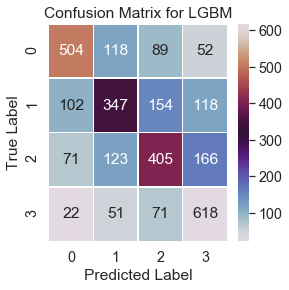

In [43]:
# Plot confusion matrix 
logreg_matrix = confusion_matrix(y_true=y_test, y_pred=clf.predict(X_test))
sns.set(font_scale=1.3)
plt.subplots(figsize=(4, 4))
sns.heatmap(logreg_matrix, annot=True, cbar=True, cmap='twilight',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for LGBM');

In [44]:
# score = 'accuracy'
# print("# Tuning hyper-parameters for %s" % score)
# print()
# np.errstate(divide='ignore')

# clf = GridSearchCV(pipeline, tuned_parameters, cv=5, scoring=score, n_jobs=4, verbose = True)
# %time clf.fit(X_train, y_train)

# print("Best parameters set found on development set:"'\n')
# print(clf.best_params_)

# print()
# print("Grid scores on development set:")
# print()
# for mean, std, params in zip(clf.cv_results_['mean_test_score'], 
#                              clf.cv_results_['std_test_score'], 
#                              clf.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [45]:
# clf.best_params_
# clf.refit
# print("Detailed classification report:")
# print(classification_report(y_test, clf.predict(X_test), digits=4))

In [46]:
# # Plot confusion matrix 
# logreg_matrix = confusion_matrix(y_true=y_test, y_pred=clf.predict(X_test))
# sns.set(font_scale=1.3)
# plt.subplots(figsize=(4, 4))
# sns.heatmap(logreg_matrix, annot=True, cbar=True, cmap='twilight',linewidth=0.5,fmt="d")
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.title('Confusion Matrix for LGBM');